Loading and Inspecting Data

In [1]:
import pandas as pd

file_path = r"C:\Users\User\Downloads\Anaconda\Online Retail\Online Retail.csv"
df = pd.read_csv(file_path, encoding='ISO-8859-1')

# Preview
print(df.head())
print(df.info())
print(df.describe())


  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  1/12/2010 8:26       2.55     17850.0  United Kingdom  
1  1/12/2010 8:26       3.39     17850.0  United Kingdom  
2  1/12/2010 8:26       2.75     17850.0  United Kingdom  
3  1/12/2010 8:26       3.39     17850.0  United Kingdom  
4  1/12/2010 8:26       3.39     17850.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo   

Data Cleaning

Removing missing values:

In [2]:
df.dropna(subset=['CustomerID', 'Description'], inplace=True)


Removing cancelled transactions:

In [3]:
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]


Removing negative or zero quantities and prices:

In [4]:
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]


Converting date column:

In [6]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], dayfirst=True)


Exploratory Data Analysis (EDA)

Top selling products:

In [7]:
top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
print(top_products)


Description
PAPER CRAFT , LITTLE BIRDIE           80995
MEDIUM CERAMIC TOP STORAGE JAR        77916
WORLD WAR 2 GLIDERS ASSTD DESIGNS     54415
JUMBO BAG RED RETROSPOT               46181
WHITE HANGING HEART T-LIGHT HOLDER    36725
ASSORTED COLOUR BIRD ORNAMENT         35362
PACK OF 72 RETROSPOT CAKE CASES       33693
POPCORN HOLDER                        30931
RABBIT NIGHT LIGHT                    27202
MINI PAINT SET VINTAGE                26076
Name: Quantity, dtype: int64


Monthly sales trend:

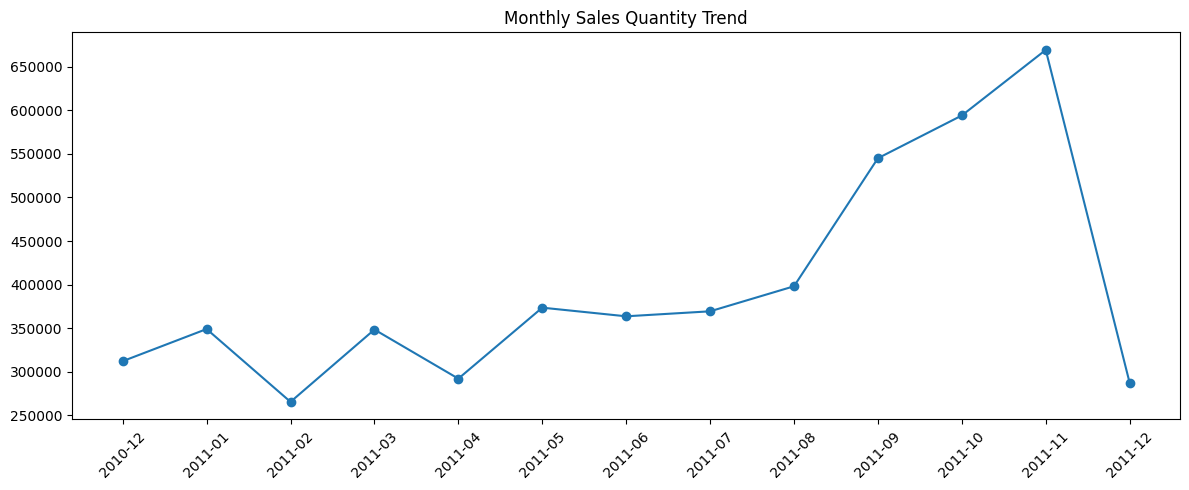

In [8]:
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')
monthly_sales = df.groupby('InvoiceMonth')['Quantity'].sum().reset_index()
monthly_sales['InvoiceMonth'] = monthly_sales['InvoiceMonth'].astype(str)

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.plot(monthly_sales['InvoiceMonth'], monthly_sales['Quantity'], marker='o')
plt.title('Monthly Sales Quantity Trend')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Feature Engineering

Total sales per transaction:

In [9]:
df['TotalSales'] = df['Quantity'] * df['UnitPrice']


Creating year, month, and weekday features:

In [10]:
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek


Aggregating daily sales for forecasting:

In [16]:
daily_sales = (
    df.drop(columns=['InvoiceMonth'], errors='ignore')
      .set_index('InvoiceDate')
      .resample('D')
      .sum(numeric_only=True)[['TotalSales']]
      .reset_index()
)


 Preprocessing for Modeling

Handling missing days (fill with 0s):

In [13]:
daily_sales = daily_sales.set_index('InvoiceDate').asfreq('D', fill_value=0).reset_index()


Creating lag features for the last 30 days

In [25]:
for lag in range(1, 31):
    daily_sales[f'lag_{lag}'] = daily_sales['TotalSales'].shift(lag)


In [26]:
daily_sales.dropna(inplace=True)


Adding Time-Based Features

In [27]:
daily_sales['DayOfWeek'] = daily_sales['InvoiceDate'].dt.dayofweek      
daily_sales['Month'] = daily_sales['InvoiceDate'].dt.month
daily_sales['IsWeekend'] = daily_sales['DayOfWeek'].isin([5, 6]).astype(int)
daily_sales['WeekOfYear'] = daily_sales['InvoiceDate'].dt.isocalendar().week.astype(int)


Handle Outliers in TotalSales

In [28]:
cap_value = daily_sales['TotalSales'].quantile(0.99)
daily_sales['TotalSales'] = daily_sales['TotalSales'].clip(upper=cap_value)


Preparing X and y 

In [29]:
X = daily_sales.drop(['InvoiceDate', 'TotalSales'], axis=1)
y = daily_sales['TotalSales']


 Train-Test Split

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)


In [33]:
daily_sales['rolling_mean_7'] = daily_sales['TotalSales'].rolling(window=7).mean().shift(1)
daily_sales['rolling_std_7'] = daily_sales['TotalSales'].rolling(window=7).std().shift(1)
daily_sales.dropna(inplace=True)


In [37]:
daily_sales['IsNoSaleDay'] = (daily_sales['TotalSales'] == 0).astype(int)


Modeling

In [38]:
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=200, max_depth=10, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(" RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print(" R²:", r2_score(y_test, y_pred))


 RMSE: 14960.070759467466
 R²: 0.4616524337355804


Visualization

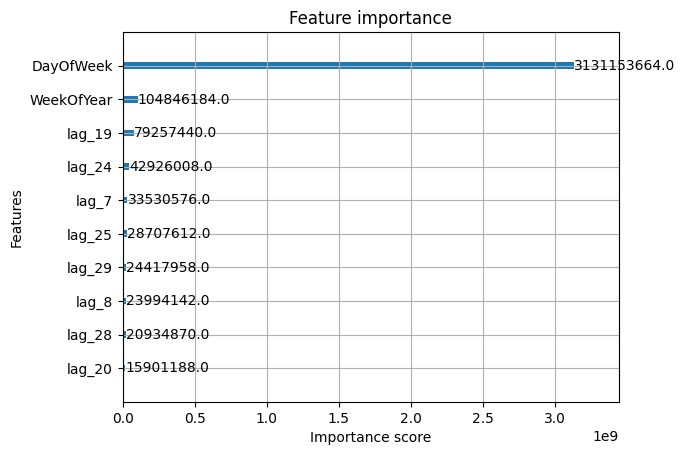

In [41]:
from xgboost import plot_importance
plot_importance(model, max_num_features=10, importance_type='gain')
plt.show()


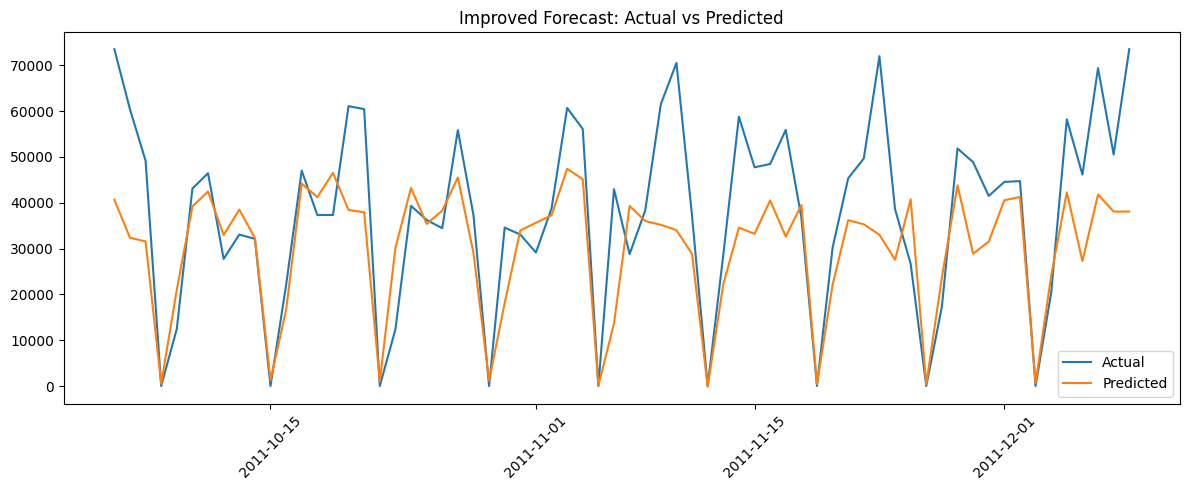

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(daily_sales['InvoiceDate'].iloc[-len(y_test):], y_test, label="Actual")
plt.plot(daily_sales['InvoiceDate'].iloc[-len(y_test):], y_pred, label="Predicted")
plt.title("Improved Forecast: Actual vs Predicted")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
